In [1]:
import os
import dill as pickle
import pandas as pd
import pycmtensor as cmt
from pycmtensor import aet as aet
from pycmtensor.expressions import Beta, Weights
from pycmtensor.optimizers import Adam
from pycmtensor.results import Results
from pycmtensor.models import MNLogit
from reslogitlayer import ResLogitLayer

cmt.logger.set_level(cmt.logger.WARNING)
cmt.__version__

'0.6.1'

In [2]:
nb_path = os.path.abspath("")
model_average_sp = pd.read_csv("data/model_average_SP.csv")
model_average_sp.columns = model_average_sp.columns.str.upper()
# model_average_sp[["AV1", "AV2"]] = 1
db = cmt.Database("model_average_sp", model_average_sp, choiceVar="CHOICE")
globals().update(db.variables)

# additional steps to format database
db.data["CHOICE"] -= 1
c = db.data.loc[:, "TT1":"HH_INC_ABS"].columns.to_list()
db.autoscale(variables=c, verbose=False)

# specify Beta parameters
b_cost = Beta("b_cost", 0.0, None, None, 0)
b_time = Beta("b_time", 0.0, None, None, 0)
b_hw = Beta("b_hw", 0.0, None, None, 0)
b_ch = Beta("b_ch", 0.0, None, None, 0)
b_hh_inc1 = Beta("b_hh_inc1", 0.0, None, None, 1)
b_hh_inc2 = Beta("b_hh_inc2", 0.0, None, None, 0)
b_carav1 = Beta("b_carav1", 0.0, None, None, 0)
b_carav2 = Beta("b_carav2", 0.0, None, None, 1)
b_com = Beta("b_com", 0.0, None, None, 0)
b_shop = Beta("b_shop", 0.0, None, None, 0)
b_bis = Beta("b_bis", 0.0, None, None, 0)
b_lei = Beta("b_lei", 0.0, None, None, 0)
asc_alt1 = Beta("asc_alt1", 0.0, None, None, 0)
asc_alt2 = Beta("asc_alt2", 0.0, None, None, 1)

# specify weight parameters
W1 = Weights("ResNet_01a", (2, 10), 0, True)
W2 = Weights("ResNet_01b", (10, 2), 0, True)

U_1 = (
    b_cost * db["TC1"]
    + b_time * db["TT1"]
    + b_hw * db["HW1"]
    + b_ch * db["CH1"]
    + b_hh_inc1 * db["HH_INC_ABS"]
    + b_carav1 * db["CAR_AVAILABILITY"]
    + b_com * db["COMMUTE"]
    + b_bis * db["BUSINESS"]
    + asc_alt1
)
U_2 = (
    b_cost * db["TC2"]
    + b_time * db["TT2"]
    + b_hw * db["HW2"]
    + b_ch * db["CH2"]
    + b_hh_inc2 * db["HH_INC_ABS"]
    + b_shop * db["SHOPPING"]
    + b_lei * db["LEISURE"]
    + b_carav2 * db["CAR_AVAILABILITY"]
    + asc_alt2
)

# Associate utility functions with the list
U = [U_1, U_2]

U = ResLogitLayer(U, W1, W2).output

# Associate the availability conditions with the alternatives
# av = [db["AV1"], db["AV2"]]

# rll = ResLogitLayer(U, W1, W2)
model = MNLogit(U, av=None, database=db, name="mymodel")
model.add_params(locals())
model.config["patience"] = 36000
model.config["base_lr"] = 0.005
model.config["max_lr"] = 0.01
model.config["cyclic_lr_step_size"] = 32


# train function
model = cmt.train(
    model,
    database=db,
    optimizer=Adam,
    batch_size=128,
    max_epoch=900,
    notebook=True,
)

with open("mymodel.pkl", "rb") as f:
    model = pickle.load(f)

result = Results(model, db, show_weights=True)


dataset: model_average_sp (n=2790)
batch size: 128
iterations per epoch: 21


Loglikelihood:  -1955.497  Score: 0.498

Epoch    0/18900:   0%|          | 0.00/18.9k [00:00<?, ?it/s]

[2022-03-09 14:05:09] WARNING: Maximum patience reached. Early stopping...


Optimization complete with accuracy of 79.677%. Max loglikelihood reached @ epoch 899.

Results for model: mymodel
Build time: 00:00:17
Estimation time: 00:00:42
Estimation rate: 21.636 epochs/s
Seed value: 999
Number of Beta parameters: 11
Tensor size: 40
Sample size: 2790
Excluded data: 0
Init loglikelihood: -1955.497
Final loglikelihood: -1281.076
Final loglikelihood reached at: epoch 899
Likelihood ratio test: 1348.842
Accuracy: 79.677%
Rho square: 0.345
Rho bar square: 0.319
Akaike Information Criterion: 2664.15
Bayesian Information Criterion: 2966.78
Final gradient norm: 0.027



In [4]:
result.print_beta_statistics()
result.print_correlation_matrix()
result.print_nn_weights()


Statistical Analysis:
              Value   Std err    t-test   p-value Rob. Std err Rob. t-test Rob. p-value
asc_alt1   0.220101   0.68068  0.323354  0.746427     0.328108    0.670819     0.502336
b_bis     -0.303434   0.69825 -0.434563   0.66388     0.280392   -1.082176     0.279174
b_carav1  -0.107228  0.044603 -2.404054  0.016214     0.009731  -11.019657          0.0
b_ch      -0.601576   0.04428 -13.58582       0.0     0.016956  -35.477942          0.0
b_com     -0.099198  0.680518 -0.145768  0.884105     0.305341   -0.324874     0.745276
b_cost    -9.763682  1.243631 -7.850949       0.0     0.044437   -219.7172          0.0
b_hh_inc2  0.007594  0.042546  0.178479  0.858346     0.018091    0.419734     0.674679
b_hw      -0.240083  0.018153  -13.2253       0.0     0.004854  -49.464296          0.0
b_lei      0.090374  0.683498  0.132223  0.894808     0.335096    0.269696     0.787394
b_shop      0.03144  0.702134  0.044778  0.964284     0.389884    0.080639     0.935729
b_time    

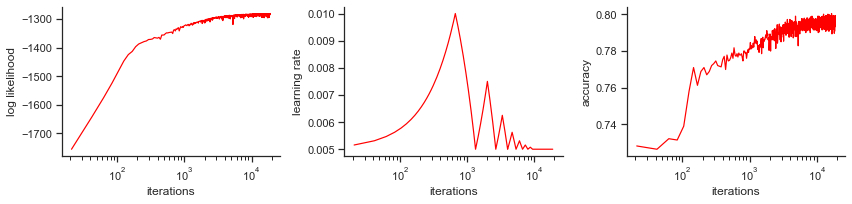

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1., rc={"lines.linewidth": 1.2})
log = model.tracker.get_data()
fig, axs = plt.subplots(1, 3, figsize=(12, 3), squeeze=False)
g1 = sns.lineplot(ax=axs[0, 0], data=log, x=log.index, y="full_ll", color='red') 
g2 = sns.lineplot(ax=axs[0, 1], data=log, x=log.index, y="lr", color='red')
g3 = sns.lineplot(ax=axs[0, 2],data=log, x=log.index, y="score", color='red') # y = score or full_ll or lr
g1.set(xscale="log", xlabel="iterations", ylabel="log likelihood")
g2.set(xscale="log", xlabel="iterations", ylabel="learning rate")
g3.set(xscale="log", xlabel="iterations", ylabel="accuracy")
sns.despine()
plt.tight_layout()
plt.show()